In [89]:
import pandas as pd
from datasets import Dataset
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import random
import torch.nn.utils
import textwrap
import re
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
from torchsummary import summary
import torch.nn.functional as F
import tiktoken
from transformers import AutoTokenizer
from datasets import load_dataset
import math
import datasets
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader

In [90]:
# Read in pandas dataframe
df = pd.read_pickle('prompt_response_pairs.pkl')

# Convert the DataFrame to a Hugging Face dataset
qa_dataset = Dataset.from_pandas(df)

print(qa_dataset)

Dataset({
    features: ['good', 'bad'],
    num_rows: 40
})


In [91]:
# Define Tokenization function that is applied to the Dataset
def tokenization(example):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
    tokenizer.pad_token = tokenizer.eos_token
    # return tokenizer(example['good'], example['bad'],padding=True, truncation=True)
    tokenized_good = tokenizer(example['good'],padding='max_length', truncation=True,max_length=50)
    tokenized_bad = tokenizer(example['bad'],padding='max_length', truncation=True, max_length=50)
    return {"good_input_ids": tokenized_good["input_ids"], "bad_input_ids": tokenized_bad["input_ids"],
            "good_attention_mask": tokenized_good["attention_mask"], "bad_attention_mask": tokenized_bad["attention_mask"]}

In [92]:
# Apply tokenization to the dataset
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer.pad_token = tokenizer.eos_token
tokenized_dataset = qa_dataset.map(tokenization, batched=True, num_proc=8)
# Save tokenized dataset
tokenized_dataset.save_to_disk('tokenized_qa_dataset')
# tokenized_dataset = tokenized_dataset.remove_columns(["text"])
# tokenized_dataset = tokenized_dataset.remove_columns(["good", "bad"])
# Load dataset into dataloader object
data_collator = DataCollatorWithPadding(tokenizer=tokenization, return_tensors="pt")

def custom_collate_fn(batch):
    # Extracting 'good_input_ids' and 'bad_input_ids' from the batch
    good_seqs = [torch.tensor(item['good_input_ids']) for item in batch]
    bad_seqs = [torch.tensor(item['bad_input_ids']) for item in batch]

    return {'good_input_ids': good_seqs, 'bad_input_ids': bad_seqs}

train_loader = DataLoader(tokenized_dataset, batch_size=10, shuffle=True,collate_fn=custom_collate_fn)

Map (num_proc=8):   0%|          | 0/40 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/40 [00:00<?, ? examples/s]

In [93]:
# print(tokenized_dataset['good_input_ids'])
for token_ids in tokenized_dataset['good_input_ids']:
    print(tokenizer.decode(token_ids))

Why is the sky blue? The sky is blue because of the way sunlight is scattered in the sky.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
Why is the sky blue? The sky is blue because of the way sunlight is scattered in the sky.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
What sound does a cow make? A cow makes a moo sound.<|endoftext|><

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
# Define transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_feature_dim, d_model, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(input_feature_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dropout=0.1,dim_feedforward=2048),
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model),
        )
        self.fc = nn.Linear(d_model, input_feature_dim)
        self.pos_encoder = PositionalEncoding(d_model)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        mask = self.generate_square_subsequent_mask(len(x)).to(device)
        x = x.permute(1,0,2)
        x = self.transformer(x, mask)
        x = x.permute(1,0,2)
        x = self.fc(x)
        return x
    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        
        x = x + (self.pe[:x.size(0)])
        return x

In [114]:
# Set parameters of Transformer model
input_feature_dim = tokenizer.vocab_size
hidden_size = 256
num_heads = 6
num_layers = 6
transformer_model = TransformerModel(input_feature_dim, hidden_size-(hidden_size%num_heads), num_heads=num_heads, num_layers=num_layers).to(device)
# Load Pre-trained model weights
transformer_model.load_state_dict(torch.load('transformer_model.pth'))
pad_token = tokenizer.encode(tokenizer.pad_token)[0]
criterion = nn.CrossEntropyLoss(ignore_index=pad_token)
optimizer = optim.AdamW(transformer_model.parameters(), lr = 0.0001, betas=(0.9, 0.95))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
# train_temperature = 1.0


In [115]:
# Remove gradient calculation for all parameters in the model
for param in transformer_model.parameters():
    param.requires_grad = False

# Enable training only for the fully connected layer
for param in transformer_model.fc.parameters():
    param.requires_grad = True

In [130]:
num_epochs = 200
training_loss_values = []
training_error_values = []
validation_loss_values = []
validation_error_values = []
x_val = 1


for epoch in range(num_epochs):
    for i,input in enumerate(train_loader):
            good_sequence = torch.stack(input['good_input_ids'],dim=0).to(device)
            bad_sequence = torch.stack(input['bad_input_ids'],dim=0).to(device)
            transformer_model.train()
            good_labels = good_sequence[:,1:].contiguous().view(-1)
            good_output = transformer_model(good_sequence[:,:-1])
            bad_labels = bad_sequence[:,1:].contiguous().view(-1)
            bad_output = transformer_model(bad_sequence[:,:-1])
            
            good_output = good_output.view(-1, good_output.size(-1))
            bad_output = bad_output.view(-1, bad_output.size(-1))
            
            primary_loss = criterion(good_output,good_labels)
            regularized_loss = torch.sigmoid(primary_loss - criterion(bad_output,bad_labels))
            total_loss = primary_loss + regularized_loss
            optimizer.zero_grad()
            total_loss.backward()
            # torch.nn.utils.clip_grad_norm_(rnn.parameters(), 15.0)
            optimizer.step()
            
            predicted_labels = torch.argmax(good_output,dim=1)
            training_error = 1.0 - (good_labels == predicted_labels).sum()/(len(good_labels))

            training_loss_values.append(total_loss.item())
            training_error_values.append(training_error.item())

            if (x_val % 1000) == 0:
                transformer_model.eval()
                print('Iteration: {}/{}'.format(x_val, len(train_loader)))

                # test_loss_accumulator = 0
                # test_error_accumulator = 0
                
                # # Validation
                # for j in range(num_validation_seq):
                #     future_sequence = torch.tensor(tokenized_train_dataset[i+j+1]['input_ids']).to(device)
                #     # future_tokens = encoding.encode(future_input)
                #     # future_sequence = torch.tensor(future_tokens).long().to(device)
                #     future_output = transformer_model(future_sequence[:-1])
                #     future_labels = future_sequence[1:]
                #     future_loss = criterion(future_output, future_labels)
                #     # future_softmaxed_logits = softmax_with_temperature(future_output, train_temperature)
                #     # future_loss = nn.NLLLoss()(torch.log(future_softmaxed_logits), future_labels)
                #     # validation_loss_values.append(future_loss.item())
                #     test_loss_accumulator += future_loss.item()
                #     future_predicted_labels = torch.argmax(future_output, dim=1)
                #     validation_error = (1.0 - (future_labels == future_predicted_labels).sum() / (len(future_sequence) - 1)).item()
                #     # validation_error_values.append(validation_error.item())
                #     test_error_accumulator += validation_error
                # validation_loss_values.append((test_loss_accumulator/num_validation_seq))
                # validation_error_values.append((test_error_accumulator/num_validation_seq))
                # validation_x_vals.append(x_val)
            
            # if x_val==10000:
            #     break
                
            x_val +=1
            primary_loss.detach(), regularized_loss.detach(), total_loss.detach()
            del primary_loss, regularized_loss, total_loss, good_sequence, bad_sequence, good_labels, bad_labels, good_output, bad_output
        # print(prof.key_averages().table(sort_by="cuda_time_total"))
            # scheduler.step()

In [131]:
torch.save(transformer_model.state_dict(), 'transformer_SFT_model.pth')
print('Model saved')

Model saved


<Figure size 640x480 with 0 Axes>

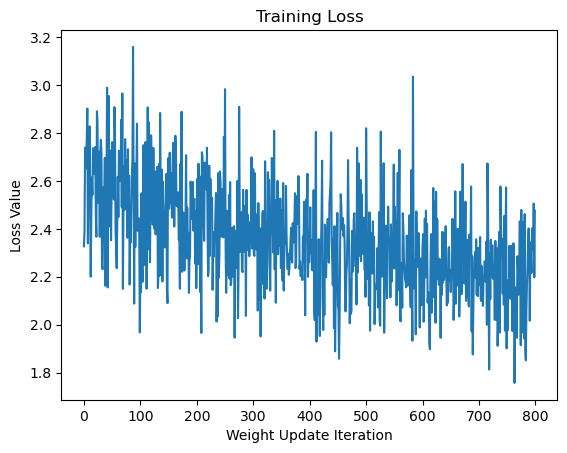

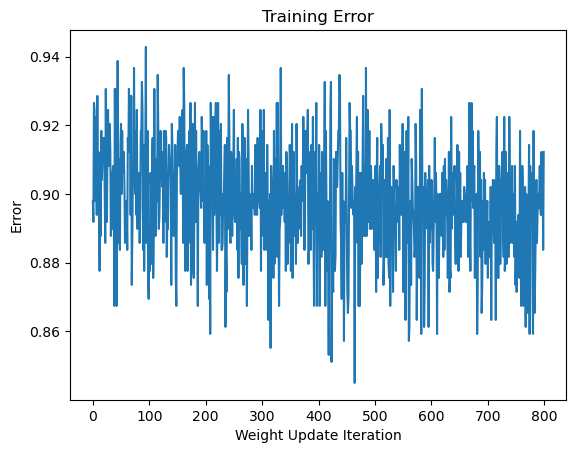

<Figure size 640x480 with 0 Axes>

In [132]:
x_vals = np.arange(x_val-1)

plt.figure()
plt.plot(x_vals,training_loss_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Loss Value')
plt.title('Training Loss')
plt.figure()
plt.plot(x_vals, training_error_values)
plt.xlabel('Weight Update Iteration')
plt.ylabel('Error')
plt.title('Training Error')
plt.figure()

In [133]:
def softmax_with_temperature(logits, temperature):
    return F.softmax(logits / temperature, dim=-1)

In [144]:
test_temperature = 0.7
transformer_model.eval()
capital_letters = [chr(i) for i in range(65, 91)]
example_sentences = []
initialize = ["How are you doing?"]
# initialize = ['Alice and Jack walked up the street and met a girl in a red dress. The girl said to them, ”Hi, I’m Jane. What are your names?”']
# initialize = ['Tom and Jane are friends. One day, Jane goes to Tom’s house. Tom has a big pot of soup. He wants to share it with Jane. “Jane, do you want some soup?” Tom asks. “Yes, please. It looks yummy,” Jane says. Tom pours some soup into two bowls. He gives one bowl to Jane. Jane takes a spoonful of soup, but then she makes a face. The soup is']
inference_tokens = 20
for i in range(1):
    sentence = initialize[i]
    tokenized_sentence = tokenizer.encode(sentence)
    next_char = torch.tensor(tokenized_sentence).long().unsqueeze(0).to(device)
    for j in range(inference_tokens):
        next_char = transformer_model(next_char)
        # print(next_char.shape)
        # print(next_char.shape)
        next_softmax = softmax_with_temperature(next_char, test_temperature)
        # predicted_char = torch.argmax(next_softmax,dim=1)
        predicted_char = torch.multinomial(next_softmax[0,-1],1)
        # letter = unique_chars[predicted_char[-1]]
        letter = tokenizer.decode([predicted_char.item()])
        sentence += letter
        # next_char = torch.tensor(tokenize(sentence)).long().to(device)
        next_tokenized_sentence = tokenizer.encode(sentence)
        next_char = torch.tensor(next_tokenized_sentence).unsqueeze(0).long().to(device)
    example_sentences.append(sentence)
example_sentences = np.array(example_sentences)
print(example_sentences[0])
# print(example_sentences[1])
# print(example_sentences[2])
# print(example_sentences[3])
# print(example_sentences[4])

How are you doing? A ball is round. The ball is round. The ball has the ceiling. The One ball has
